# Content

>[Content](#scrollTo=9CWyV4beAH0q&uniqifier=2)

>[Generative AI](#scrollTo=d95n8HFhAJ3m&uniqifier=2)

>>[OpenAI](#scrollTo=i4ToZgP9-rIo&uniqifier=2)

>>>[Few shot Prompt](#scrollTo=wW5Py1HkneoI&uniqifier=2)

>>>[Function Calling](#scrollTo=_sHjRxqRu1SE&uniqifier=2)

>>[LangChain](#scrollTo=VaZgHOlOly0L&uniqifier=2)

>>>[Prompt Templating](#scrollTo=Qrmc6aYCmyBE&uniqifier=2)

>>>[Agents](#scrollTo=OSJlfKhYm05y&uniqifier=2)

>>>[Chains](#scrollTo=wZB8-VEzm0qW&uniqifier=2)

>>>[Document Loader](#scrollTo=094HkTgJ3LgE&uniqifier=2)

>>>[Memory](#scrollTo=1yM7479RABo5&uniqifier=2)

>>>>[Conversation Buffer Memory](#scrollTo=xUDLj9bZDX1H&uniqifier=2)

>>>>[Conversation Chain](#scrollTo=34Wx_PAVHJZc&uniqifier=2)

>>>>[Conversation Buffer Window Memory](#scrollTo=bE0qBhKn1sfW&uniqifier=2)

>>[Hugging Face](#scrollTo=4J6b25uaB5TP&uniqifier=2)

>>>[Using Models from HuggingFace](#scrollTo=Pq3G4sxRDmAH&uniqifier=2)

>>>[Downloading Models Locally](#scrollTo=9VtpZ9UlMPlr&uniqifier=2)

>>[Llama](#scrollTo=cIbus3vrIFjB&uniqifier=2)

>>>[Llama CPP Python](#scrollTo=KwSz42p_TGN4&uniqifier=2)

>>>[Llama with Langchain](#scrollTo=U_LQmLSHMnoO&uniqifier=2)

>>[LangGraph](#scrollTo=e7WbSwZe0sd1&uniqifier=2)

>>>[Agent Executor](#scrollTo=NcVLSks00vwG&uniqifier=2)

>>>[Chat Agent Executor](#scrollTo=ZVSc3odHCyAG&uniqifier=2)

>>>[Multi-Agent Workflows](#scrollTo=SxZnY3SCO-jU&uniqifier=2)

>>>>[Agent Supervisor](#scrollTo=9iMJUxC7A8-C&uniqifier=2)

>>[CrewAI](#scrollTo=kyZD8W_RdoXA&uniqifier=2)

>>>[Agentic Design Pattern](#scrollTo=MPxfeexmdq3h&uniqifier=2)

>>>[Multi-Agent Systems](#scrollTo=4HrBs6wseFgJ&uniqifier=2)

>>>>[Article Writer Example](#scrollTo=tGUx0w7JmHsO&uniqifier=2)

>>>>[Customer Support Automation Example](#scrollTo=F5HL_6fumNPC&uniqifier=2)

>>>[CrewAI Tools](#scrollTo=NVQh0lz0tHFK&uniqifier=2)

>[Vector Databases](#scrollTo=3TY5pCv8w-5H&uniqifier=2)

>>[Pinecone VectorDB](#scrollTo=fX0221ouxAfx&uniqifier=2)

>>>[Creating Embeddings from text chunks](#scrollTo=ChlWuiNPB4er&uniqifier=2)

>>>[Querying VectorDB](#scrollTo=WtglMMDjKD-i&uniqifier=2)

>>[ChromaDB](#scrollTo=kD8z-5adnZ4T&uniqifier=2)

>>>[Creating ChromaDB](#scrollTo=glV_-rzq8mBE&uniqifier=2)

>>>[Retrieval](#scrollTo=EtSO9IhK-iZC&uniqifier=2)

>>>[Making a Chain](#scrollTo=Rz1W-meADHuS&uniqifier=2)

>>>[Removing ChromaDB](#scrollTo=nTnNTxUCHD2o&uniqifier=2)

>[Serving LLMs](#scrollTo=revomOFbe7lN&uniqifier=2)

>>[Text Generation](#scrollTo=TnghqQQsfv96&uniqifier=2)

>>>[Optimizing text generation with KV-caching](#scrollTo=1lj8HSS1gwsP&uniqifier=2)

>>[Batching](#scrollTo=XxoSxWcQi-wj&uniqifier=2)

>>>[Throughput vs Latency](#scrollTo=l5kHfIoDoMwa&uniqifier=2)

>>>[Continuous Batching](#scrollTo=M6VLBm8Wtom0&uniqifier=2)

>>[Quantization](#scrollTo=MPwF3Y_PV3T0&uniqifier=2)

>[Fine-Tuning](#scrollTo=s8tRQu9eS9Yv&uniqifier=2)

>>[Parameter-Efficient Fine-Tuning (PEFT)](#scrollTo=-WFpUVghVoad&uniqifier=2)

>>[Adapter Tuning](#scrollTo=8T4beGTiWInB&uniqifier=2)

>>>[AdapterFusion](#scrollTo=p0rZtDfybRt8&uniqifier=2)

>>[Low-Rank Adaptation (LoRA)](#scrollTo=ssTHZig_CFSb&uniqifier=2)

>>>[Implementing LoRA](#scrollTo=nUppikWVgfwZ&uniqifier=2)

>>>[Implementing Multi-LoRA](#scrollTo=lnFGYyZskYxD&uniqifier=2)

>>[Quantization](#scrollTo=c80BXEChZl2h&uniqifier=2)

>>>[4-Bit NormalFloat Quantization](#scrollTo=jZARw3V4Z5v3&uniqifier=2)

>>>[Quantization and Low Rank Adaptors (QLoRA)](#scrollTo=gqa83-O9gTE_&uniqifier=2)

>>>>[Implementation](#scrollTo=xM44VjYlhpRV&uniqifier=2)

>>>[Mixed Precision Training](#scrollTo=BE6k_bXIzJ6A&uniqifier=2)



# Generative AI

## OpenAI

In [ ]:
!pip install openai

In [ ]:
import openai
print(openai.__version__)

1.14.1


In [ ]:
openai_api_key = "" # @param {type:"string"}

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

In [ ]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
    {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
  ], # Roles: system, user, assistant, tool
  max_tokens=128, # Maximum number of tokens you want result
  temperature=1, # How creative the output should be
  n=2 # Number of the outputs
)

print(completion.choices[0].message)

ChatCompletionMessage(content='In the realm of code, a concept lives and breathes,\nWhere functions call themselves, like whispers in the trees.\nRecursion is the art, a trance-like dance,\nUnfolding mysteries with each recursive glance.\n\nLike a mirror reflecting its own reflection,\nA function loops back, with no objection.\nIt breaks down a problem, into smaller parts,\nAnd solves them one by one, with gentle smarts.\n\nA journey through layers, like a dream unfurled,\nEach invocation a thread in the code world.\nIt reaches the base case, like a destination,\nUnwinding the stack, with jubilation.\n\nSo embrace recursion, with courage and grace,\nLet it guide your code through time and space.\nFor in its elegant cycle, we find our place,\nA recursive enchantment, woven with grace.', role='assistant', function_call=None, tool_calls=None)


**This is an example of zero shot prompt**

### Few shot Prompt


In [ ]:
person_info="My name is Cyrus, I'm a software engineer at X, and I live in Canada."

In [ ]:
prompt = f'''
Extract the following information from the given text and return it as a JSON object:

name
job
company
country

This is the body of text to extract the information from:
{person_info}
'''

In [ ]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt}
  ]
)

print(completion.choices[0].message.content)

{
  "name": "Cyrus",
  "job": "software engineer",
  "company": "X",
  "country": "Canada"
}


**This is an example of few shot prompt**

### Function Calling

In [ ]:
import json

# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": unit})
    elif "san francisco" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "72", "unit": unit})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": unit})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})


In [ ]:
# Step 1: send the conversation and available functions to the model
messages = [{"role": "user", "content": "What's the weather like in San Francisco, Tokyo, and Paris?"}]
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                },
                "required": ["location"],
            },
        },
    }
]

response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=messages,
    tools=tools,
    tool_choice="auto",  # auto is default, but we'll be explicit
)
response_message = response.choices[0].message
tool_calls = response_message.tool_calls

In [ ]:
# Step 2: check if the model wanted to call a function
if tool_calls:
    # Step 3: call the function
    # Note: the JSON response may not always be valid; be sure to handle errors
    available_functions = {
        "get_current_weather": get_current_weather,
    }  # only one function in this example, but you can have multiple
    messages.append(response_message)  # extend conversation with assistant's reply
    # Step 4: send the info for each function call and function response to the model
    for tool_call in tool_calls:
        print(tool_call)
        function_name = tool_call.function.name
        function_to_call = available_functions[function_name]
        function_args = json.loads(tool_call.function.arguments)
        function_response = function_to_call(
            location=function_args.get("location"),
            unit=function_args.get("unit"),
        )
        messages.append(
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            }
        )  # extend conversation with function response
    second_response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
    )  # get a new response from the model where it can see the function response
    print(second_response.choices[0].message.content)

ChatCompletionMessageToolCall(id='call_Q6tNs8Yd24ROxqmgrMYYYAC1', function=Function(arguments='{"location": "San Francisco", "unit": "celsius"}', name='get_current_weather'), type='function')
ChatCompletionMessageToolCall(id='call_efCZ1xEyMhMqKCVvFNsU3gax', function=Function(arguments='{"location": "Tokyo", "unit": "celsius"}', name='get_current_weather'), type='function')
ChatCompletionMessageToolCall(id='call_UgPOHn0Gls5GEtPiNdYlseoB', function=Function(arguments='{"location": "Paris", "unit": "celsius"}', name='get_current_weather'), type='function')
Currently in San Francisco, the weather is 72°C. In Tokyo, it is 10°C, and in Paris, it is 22°C.


## LangChain

In [ ]:
!pip install langchain

In [ ]:
import langchain
print(langchain.__version__)

0.1.12


In [ ]:
from langchain.llms import OpenAI
client=OpenAI(openai_api_key=openai_api_key)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [ ]:
# Zero shot prompting
prompt="Can you tell me total number of counntries in north america"
print(client.invoke(prompt))



There are 23 countries in North America. They are:

1. Antigua and Barbuda
2. Bahamas
3. Barbados
4. Belize
5. Canada
6. Costa Rica
7. Cuba
8. Dominica
9. Dominican Republic
10. El Salvador
11. Grenada
12. Guatemala
13. Haiti
14. Honduras
15. Jamaica
16. Mexico
17. Nicaragua
18. Panama
19. Saint Kitts and Nevis
20. Saint Lucia
21. Saint Vincent and the Grenadines
22. Trinidad and Tobago
23. United States of America


### Prompt Templating

In [ ]:
from langchain.prompts import PromptTemplate
prompt_template = PromptTemplate(
    input_variables=["country"],
    template="Can you tell me the capital {country}"
)
prompt_template

PromptTemplate(input_variables=['country'], template='Can you tell me the capital {country}')

In [ ]:
prompt = prompt_template.format(country="Canada")

In [ ]:
print(client.invoke(prompt))



The capital of Canada is Ottawa.


In [ ]:
prompt_template = PromptTemplate.from_template("What is the language of {country}")

In [ ]:
prompt_template.format(country="Canada")

'What is the language of Canada'

### Agents

Used to call third-party tools

In [ ]:
prompt_template = PromptTemplate.from_template("What is the weather in {city} now?")
prompt=prompt_template.format(city="Ottawa")

In [ ]:
print(client.invoke(prompt)) # Not a good answer



I am an AI and do not have access to real-time weather data. Please check a weather website or app for the current weather in Ottawa.


In [ ]:
!pip install google-search-results

In [ ]:
serp_api_key = "" # @param {type:"string"}

In [ ]:
from langchain.agents import AgentType, load_tools, initialize_agent

In [ ]:
tool = load_tools(["serpapi"], serpapi_api_key=serp_api_key, llm=client)
tool

[Tool(name='Search', description='A search engine. Useful for when you need to answer questions about current events. Input should be a search query.', func=<bound method SerpAPIWrapper.run of SerpAPIWrapper(search_engine=<class 'serpapi.google_search.GoogleSearch'>, params={'engine': 'google', 'google_domain': 'google.com', 'gl': 'us', 'hl': 'en'}, serpapi_api_key='46f2201c74213cb9e5f88667f9bc98ea9b2ce2343d5cc3a206bc5c67c9c85b33', aiosession=None)>, coroutine=<bound method SerpAPIWrapper.arun of SerpAPIWrapper(search_engine=<class 'serpapi.google_search.GoogleSearch'>, params={'engine': 'google', 'google_domain': 'google.com', 'gl': 'us', 'hl': 'en'}, serpapi_api_key='46f2201c74213cb9e5f88667f9bc98ea9b2ce2343d5cc3a206bc5c67c9c85b33', aiosession=None)>)]

In [ ]:
agent=initialize_agent(
    tool,
    client,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [ ]:
agent.run(prompt)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
 I should use the search engine to find the current weather in Ottawa
Action: Search
Action Input: "weather in Ottawa"
Observation: {'type': 'weather_result', 'temperature': '33', 'unit': 'Fahrenheit', 'precipitation': '19%', 'humidity': '91%', 'wind': '8 mph', 'location': 'Ottawa, ON, Canada', 'date': 'Tuesday 11:00 PM', 'weather': 'Cloudy'}
Thought: The current weather in Ottawa is cloudy with a temperature of 33 degrees Fahrenheit.
Final Answer: The current weather in Ottawa is cloudy with a temperature of 33 degrees Fahrenheit.

> Finished chain.


'The current weather in Ottawa is cloudy with a temperature of 33 degrees Fahrenheit.'

### Chains

Chains refer to sequences of calls - whether to an LLM, a tool, or a data preprocessing step.

In [ ]:
from langchain.prompts import PromptTemplate
prompt_template1 = PromptTemplate.from_template("What is a good name for a {obj} bussiness? (Only one example)")
prompt_template2 = PromptTemplate.from_template("Creating a startup with the name {name} , give me ideas?")

In [ ]:
from langchain.chains import LLMChain

name_chain = LLMChain(llm=client, prompt=prompt_template1, output_key="name")

In [ ]:
print(name_chain.run("flower"))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




"Blooming Blossoms" 


In [ ]:
idea_chain = LLMChain(llm=client, prompt=prompt_template2, output_key="ideas")

In [ ]:
from langchain.chains import SimpleSequentialChain
chain=SimpleSequentialChain(chains=[name_chain, idea_chain])

In [ ]:
print(chain.run("flower"))



1. A unique and personalized floral subscription service, where customers can receive a fresh bouquet of flowers every week or month.

2. Offering floral arrangements for special events such as weddings, birthdays, and corporate events.

3. Partnering with local businesses to provide floral arrangements for their offices or storefronts.

4. Hosting workshops and classes on floral arrangement and design for individuals or groups.

5. Developing a line of eco-friendly and sustainable floral products, such as biodegradable flower pots and packaging.

6. Providing flower delivery services for last-minute gifts or special occasions.

7. Collaborating with local artists to create unique and one-of-a-kind floral art installations for public spaces.

8. Offering a selection of dried and preserved flowers for long-lasting home decor.

9. Creating a social media presence to showcase the beauty of flowers and engage with customers.

10. Partnering with local flower farms to source fresh, locall

**Alternative syntax**

In [ ]:
chain = prompt_template1 | client

print(chain.invoke({"obj": "flower bussiness"}))



"Petals & Blooms Co."


In [ ]:
def str_parser(input):
  print(input)
  return {"name": input}

chain = prompt_template1 | client | str_parser | prompt_template2 | client
print(chain.invoke({"obj": "flower bussiness"}))



"Blooming Oasis Florals"


1. Unique floral arrangements: Offer a variety of unique and creative floral arrangements, such as succulent bouquets, preserved flower displays, and personalized floral designs.

2. Subscription services: Provide a subscription service for weekly or monthly flower deliveries to homes and businesses, offering a convenient and cost-effective option for customers.

3. Event and wedding services: Partner with event planners and wedding venues to offer floral design services for special occasions, including customized centerpieces, bouquets, and installations.

4. Online presence: Create a strong online presence through a website and social media platforms to showcase your work, promote your services, and interact with customers.

5. Green and sustainable practices: Promote eco-friendly and sustainable practices, such as using locally sourced flowers and recyclable packaging, to appeal to environmentally conscious customers.

6. Collaborations: Collaborate with

Sequential Chains

In [ ]:
from langchain.chains import SequentialChain

chain=SequentialChain(
    chains=[name_chain, idea_chain],
    input_variables=["obj"],
    output_variables=["name", "ideas"]
    )

In [ ]:
chain({"obj": "flower"})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


{'obj': 'flower',
 'name': '\n\n"Petals & Blooms Floral Co." ',
 'ideas': ' \n\n1. Online Flower Delivery Service: Offer a convenient and easy way for customers to order and send flowers to their loved ones with same-day delivery options.\n\n2. Custom Floral Arrangements: Create unique and personalized floral arrangements for special occasions such as weddings, birthdays, and anniversaries.\n\n3. Subscription Services: Offer a subscription service where customers can receive a fresh bouquet of flowers every week or month.\n\n4. Event Planning and Decor: Partner with event planners and offer floral decor for weddings, corporate events, and other special occasions.\n\n5. Floral Workshops: Host workshops for customers to learn how to create their own floral arrangements and bouquets.\n\n6. Greenhouse and Nursery: Have a greenhouse and nursery on-site where customers can purchase plants and flowers for their home or garden.\n\n7. Corporate Gifting: Partner with businesses to provide custom

### Document Loader

In [ ]:
!pip install pypdf langchain_openai  faiss-cpu

In [ ]:
!wget https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf

--2024-03-21 02:42:10--  https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf
Resolving papers.neurips.cc (papers.neurips.cc)... 198.202.70.94
Connecting to papers.neurips.cc (papers.neurips.cc)|198.202.70.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf [following]
--2024-03-21 02:42:10--  https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
Resolving proceedings.neurips.cc (proceedings.neurips.cc)... 198.202.70.94
Connecting to proceedings.neurips.cc (proceedings.neurips.cc)|198.202.70.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569417 (556K) [application/pdf]
Saving to: ‘7181-attention-is-all-you-need.pdf’

7181-attention-is-a 100%[===================>] 556.07K  1.69MB/s    in 0.3s    

2024-03-21 02:42:11 (1.69 MB/s) - ‘7181-attention-is-all-you-need.pdf’

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("/content/7181-attention-is-all-you-need.pdf")
pages = loader.load_and_split()

In [ ]:
len(pages), pages[0]

(12,
 Document(page_content='Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more parallelizable and requ

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

faiss_index = FAISS.from_documents(pages[0:3], OpenAIEmbeddings(api_key=openai_api_key))

In [ ]:
docs = faiss_index.similarity_search("What is attention?", k=2)
for doc in docs:
    print(str(doc.metadata["page"]) + ":", doc.page_content[:300])

0: Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.comNoam Shazeer∗
Google Brain
noam@google.comNiki Parmar∗
Google Research
nikip@google.comJakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.comAidan N. Gomez∗†
University of Toronto
aidan@c
1: Recurrent models typically factor computation along the symbol positions of the input and output
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden
statesht, as a function of the previous hidden state ht−1and the input for position t. This inherently
s


### Memory

In [ ]:
from langchain.prompts import PromptTemplate
prompt_template = PromptTemplate.from_template("What is a good name for a {obj} bussiness? (Only one example)")

In [ ]:
from langchain.chains import LLMChain
chain = LLMChain(llm=client, prompt=prompt_template)

In [ ]:
chain.run("AI").strip()

'"Synapse Solutions"'

In [ ]:
chain.memory

In [ ]:
type(chain.memory)

NoneType

#### Conversation Buffer Memory

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()

Manually adding to memory

```python
memory.chat_memory.add_user_message("hi!")
memory.chat_memory.add_ai_message("what's up?")
```

In [ ]:
chain = LLMChain(llm=client, prompt=prompt_template, memory=memory)

In [ ]:
chain.run("AI").strip()

'"NeuroNexus Solutions"'

In [ ]:
chain.memory

ConversationBufferMemory(chat_memory=ChatMessageHistory(messages=[HumanMessage(content='AI'), AIMessage(content='\n\n"NeuroNexus Solutions"')]))

In [ ]:
print(chain.memory.buffer)

Human: AI
AI: 

"NeuroNexus Solutions"


#### Conversation Chain

Conversation buffer memory goes growing endlessly.

Restrict to last 5 conversation chain

In [ ]:
from langchain.chains import ConversationChain
from langchain_openai import OpenAI

In [ ]:
convo = ConversationChain(llm=OpenAI(openai_api_key=openai_api_key, temperature=0.7))

In [ ]:
print(convo.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [ ]:
convo.run("Who invented the light bulb?")

' The light bulb was invented by Thomas Edison in 1879. However, he was not the only person working on this technology at the time. Other inventors like Joseph Swan and Hiram Maxim were also working on improving the design and functionality of the light bulb.'

In [ ]:
convo.run("When did he born?")

' Thomas Edison was born on February 11, 1847 in Milan, Ohio. He was the youngest of seven children and showed an interest in science and technology from a young age.'

#### Conversation Buffer Window Memory




In [ ]:
from langchain.memory import ConversationBufferWindowMemory

In [ ]:
memory=ConversationBufferWindowMemory(k=1)

In [ ]:
convo = ConversationChain(llm=OpenAI(openai_api_key=openai_api_key, temperature=0.7), memory=memory)

In [ ]:
convo.run("Who invented the light bulb?")

' The light bulb was invented by Thomas Edison in 1879. He experimented with over 6,000 different materials before discovering that carbonized bamboo worked best as a filament.'

In [ ]:
convo.run("What year is today?")

' Today is Monday, December 13, 2021.'

In [ ]:
convo.run("When did he born?")

' I do not have enough information to accurately answer your question. Who are you referring to?'

## Hugging Face

In [ ]:
!pip install huggingface_hub transformers accelerate bitsandbytes langchain

In [ ]:
!pip install langchain

In [ ]:
from langchain import PromptTemplate, HuggingFaceHub, LLMChain
import os

In [ ]:
HUGGINGFACEHUB_API_TOKEN = "" # @param {type:"string"}


In [ ]:
os.environ['HUGGINGFACEHUB_API_TOKEN']=HUGGINGFACEHUB_API_TOKEN

### Using Models from HuggingFace

In [ ]:
prompt = PromptTemplate(
    input_variables=["product"],
    template="What is a good name for a company that make {product}"
)

In [ ]:
chain = LLMChain(
    llm=HuggingFaceHub(repo_id="google/flan-t5-large", model_kwargs={'temperature': 0}),
    prompt=prompt
  )

In [ ]:
chain.run("flower")

'lilies'

### Downloading Models Locally

In [ ]:
from langchain.llms import HuggingFacePipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, AutoModelForSeq2SeqLM

In [ ]:
model_id="google/flan-t5-large"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
pline = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_length=128)

In [ ]:
local_llm = HuggingFacePipeline(pipeline=pline)

In [ ]:
prompt = PromptTemplate(
    input_variables=["item"],
    template="Tell me about {item}"
)

In [ ]:
chain = LLMChain(llm=local_llm, prompt=prompt)

In [ ]:
chain("Sun")

{'item': 'Sun',
 'text': 'Sun is a constellation in the constellation of Aries.'}

## Llama

### Llama CPP Python

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUDA=on" pip install llama-cpp-python

In [ ]:
model_name = 'TheBloke/Llama-2-13B-chat-GGUF'
model_basename= 'llama-2-13b-chat.Q5_K_M.gguf'

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [ ]:
model_path

'/root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf'

In [ ]:
!nvidia-smi

Fri Apr  5 03:00:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# GPU
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU Cores
    n_batch=1024, # Should be between 1 and n_ctx, consider the amount of VRAM in GPU
    n_gpu_layers=-1 # Change this value based on your model and your GPU VRAM pool
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

In [ ]:
prompt="Write a linear regression code"
prompt_template=f'''SYSTEM: You are a helpful assistant.

USER: {prompt}

ASSISTANT:
'''

print(prompt_template)

SYSTEM: You are a helpful assistant.

USER: Write a linear regression code

ASSISTANT:



In [ ]:
response = lcpp_llm(
    prompt=prompt_template,
    max_tokens=256,
    temperature=0.5,
    top_p=0.95,
    repeat_penalty=1.2,
    top_k=150,
    echo=True
)


llama_print_timings:        load time =     892.48 ms
llama_print_timings:      sample time =     156.96 ms /   256 runs   (    0.61 ms per token,  1631.02 tokens per second)
llama_print_timings: prompt eval time =     892.37 ms /    27 tokens (   33.05 ms per token,    30.26 tokens per second)
llama_print_timings:        eval time =   12067.04 ms /   255 runs   (   47.32 ms per token,    21.13 tokens per second)
llama_print_timings:       total time =   13926.02 ms /   282 tokens


In [ ]:
response

{'id': 'cmpl-2d9e8f48-31fa-40b8-8071-68055287c39b',
 'object': 'text_completion',
 'created': 1712286064,
 'model': '/root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf',
 'choices': [{'text': 'SYSTEM: You are a helpful assistant.\n\nUSER: Write a linear regression code\n\nASSISTANT:\n\nHere is an example of how you could write a linear regression code in Python using scikit-learn library:\n```\nimport pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\n\n# Load the data\ndf = pd.read_csv(\'data.csv\')\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(df.drop(\'target\', axis=1), df[\'target\'], test_size=0.2)\n\n# Create a linear regression object and fit it to the training data\nreg = LinearRegression()\nreg.fit(X_train, y_train)\n\n# Make predictions on the testing dat

In [ ]:
print(response['choices'][0]['text'])

SYSTEM: You are a helpful assistant.

USER: Write a linear regression code

ASSISTANT:

Here is an example of how you could write a linear regression code in Python using scikit-learn library:
```
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('data.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2)

# Create a linear regression object and fit it to the training data
reg = LinearRegression()
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = reg.predict(X_test)

# Evaluate the model using mean squared error
mse = ((y_test - y_pred) ** 2).mean()
print('Mean squared error:', mse)
```
This code assumes that you have a CSV file called "data.csv" containing the data, with


### Llama with Langchain

In [ ]:
!pip install -q transformers einops accelerate langchain bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch

In [ ]:
model="meta-llama/Llama-2-7b-hf"

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
pipeline=transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    max_length=1000,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id
)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
# This LLM can be used with all other langchain functions
llm=HuggingFacePipeline(pipeline=pipeline, model_kwargs={'temperature':0})

In [ ]:
prompt="What is a good name for a tech company"

In [ ]:
print(llm.invoke(prompt))

What is a good name for a tech company?
What is a good name for a tech company?
What is the most successful tech company?
What is the most successful tech company in the world?
What are the top 10 tech companies?
What is the best tech company to work for?
What is the best tech company to work for?
What is the best tech company in the world?
What is the most successful company in the world?
What is the most successful company in the world?
What is the best company in the world?
What is the best tech company to work for?
What is the best tech company to work for?
What is the best tech company to work for?
What is the best tech company to work for?
What is the best tech company to work for?
What is the best tech company to work for?What is the best tech company to work for?
What is the best tech company to work for?What is the best tech company to work for?What is the best tech company to work for?What is the best tech company to work for?What is the best tech company to work for?What is 

## LangGraph

Official examples: https://github.com/langchain-ai/langgraph/tree/main/examples

In [ ]:
!pip install -q -U langchain langchainhub langchain_openai openai tavily-python langgraph  langsmith langchain_experimental

### Agent Executor

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key:··········
Tavily API Key:··········


**Create the LangChain agent**

In [ ]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

# Get the prompt to use
prompt = hub.pull("hwchase17/openai-functions-agent")

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

**Define the graph sta**te

We now define the graph state. The state for the traditional LangChain agent has a few attributes:

1. **input**: This is the input string representing the main ask from the user, passed in as input.
2. **chat_history**: This is any previous conversation messages, also passed in as input.
3. **intermediate_steps**: This is list of actions and corresponding observations that the agent takes over time. This is updated each iteration of the agent.
4. **agent_outcome**: This is the response from the agent, either an AgentAction or AgentFinish. The AgentExecutor should finish when this is an AgentFinish, otherwise it should call the requested tools.

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    # The input string
    input: str
    # The list of previous messages in the conversation
    chat_history: list[BaseMessage]
    # The outcome of a given call to the agent
    # Needs `None` as a valid type, since this is what this will start as
    agent_outcome: Union[AgentAction, AgentFinish, None]
    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

**Define the nodes**

We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a runnable. There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.


We will also need to define some edges. Some of these edges may be conditional. The reason they are conditional is that based on the output of a node, one of several paths may be taken. The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either: a. If the agent said to take an action, then the function to invoke tools should be called b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next


Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [ ]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)


# Define the agent
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}


# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}


# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data["agent_outcome"], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

**Define the graph**

We can now put it all together and define the graph!

In [ ]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [ ]:
inputs = {"input": "what is the weather in sf", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in San Francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-9517941b-08d3-47c1-894d-8945838ac958-0')])}
----
{'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in San Francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-9517941b-08d3-47c1-894d-8945838ac958-0')])

### Chat Agent Executor

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

LangSmith API Key:··········


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

In [ ]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

**Set up the model**

Now we need to load the chat model we want to use. Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.

In [ ]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

In [ ]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

**Define the agent state**

The main type of graph in langgraph is the StatefulGraph. This graph is parameterized by a state object that it passes around to each node. Each node then returns operations to update that state. These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute. Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages. We want each node to just add messages to that list. Therefore, we will use a TypedDict with one key (messages) and annotate it so that the messages attribute is always added to.

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

**Define the nodes**

We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a runnable. There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.


We will also need to define some edges. Some of these edges may be conditional. The reason they are conditional is that based on the output of a node, one of several paths may be taken. The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either: a. If the agent said to take an action, then the function to invoke tools should be called b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [ ]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

**Define the graph**
We can now put it all together and define the graph!

In [ ]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

Use it!
We can now use it! This now exposes the same interface as all other LangChain runnables.

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='what is the weather in sf'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-2d0d7907-d9cc-4136-b447-2803ec05a60a-0'),
  FunctionMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1714683271, \'localtime\': \'2024-05-02 13:54\'}, \'current\': {\'last_updated_epoch\': 1714682700, \'last_updated\': \'2024-05-02 13:45\', \'temp_c\': 18.3, \'temp_f\': 64.9, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 20.6, \'wind_kph\': 33.1, \'wind_degree\': 270, \'wind_d

**Streaming**
LangGraph has support for several different types of streaming.

In [ ]:
inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-d221e860-f027-4832-a86f-493517294c50-0')]}

---

Output from node 'action':
---
{'messages': [FunctionMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1714683271, \'localtime\': \'2024-05-02 13:54\'}, \'current\': {\'last_updated_epoch\': 1714682700, \'last_updated\': \'2024-05-02 13:45\', \'temp_c\': 18.3, \'temp_f\': 64.9, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 20.6, \'wind_kph\': 33.1, \'w

### Multi-Agent Workflows


**Basic Multi-agent Collaboration**

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like gpt-4, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation, by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

![graph](https://raw.githubusercontent.com/langchain-ai/langgraph/8a38226078383d49f57cd30c0df4203b0ea7cb2d/examples/multi_agent/img/simple_multi_agent_diagram.png)



**Create Agents**
The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.

In [ ]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

**Define tools**
We will also define some tools that our agents will use in the future

In [ ]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

**Create graph**
Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

**Define State**
We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [ ]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

**Define Agent Nodes**
We now need to define the nodes. First, let's define the nodes for the agents.

In [ ]:
import functools


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart Generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

**Define Tool Node**
We now define a node to run the tools

In [ ]:
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)


def tool_node(state):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

**Define Edge Logic**
We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [ ]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

**Define the Graph**
We can now put it all together and define the graph!

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

**Invoke**
With the graph created, you can invoke it! Let's have it chart some stats for us.

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    print("----")

#### Agent Supervisor

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

![Agent Supervisor](https://raw.githubusercontent.com/langchain-ai/langgraph/8a38226078383d49f57cd30c0df4203b0ea7cb2d/examples/multi_agent/img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class from LangChain. This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

**Create tools**

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [ ]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

**Helper Utilites**

Define a helper function below, which make it easier to add new agent worker nodes.

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

We can also define a function that we will use to be the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

**Create Agent Supervisor**

It will use function calling to choose the next worker node OR finish processing.

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

**Construct Graph**

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [ ]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

Now connect all the edges in the graph.

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

Invoke the team
With the graph created, we can now invoke it and see how it performs!

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

## CrewAI

João Moura: Founder and CEO of CrewAI

### Agentic Design Pattern

In the past you would go from point a to point b, and you can write code to automate that.
and then what happens is that as edge cases appear you start to kind of make that a little more complex by adding a lot of if's and conditions there.

The beauty of agentic automation is that you don't need to draw a map, you just show all the options and let the agent choose.


Traditional: strongly typed inputs, predefined transformation steps, and a strongly typed output.

Agentic: Fuzzy inputs, fuzzy tranformations, fuzzy outputs

\

**What are Agents:**

An agent is born when you get LLMs to engage in their thinking process throughout it ask questions and answer the questions itself to the point that it can move on and ge better by itself.

Once at this stage, it allows you to pass a task to this agent, and throughout process this agent can then come up with a better answer, it's not the first answer that it would have given you but it can think through and optimize the answer upto the point that satisfies itself and then spits it out.

The ability to use tools (capabilities) make them super powerful.



### Multi-Agent Systems

It grows on top of this topic, where instead of having just one agent, you can now have multiple agents.
so each time you task an agent, it can task another agent, and at the end you would get one single final answer.

What are the benefits of this?
- You can have each agent be customized to don one single thing, and do it well
- They could be running on different LLMs

\

**What makes an agent great?**

- Role playing
- Focus
- Tools
- Cooperation
- Guardrails
- Memory

#### Article Writer Example

In [ ]:
!pip -q install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [ ]:
from crewai import Agent, Task, Crew
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import getpass
import os
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


**Creating Agents**

- Define your Agents, and provide them a `role`, `goal` and `backstory`.
- It has been seen that LLMs perform better when they are role playing.

**Agent: Planner**


In [ ]:
planner = Agent(
    role="Content Planner",
    goal="Plan engaging and factually accurate content on {topic}",
    backstory="You're working on planning a blog article "
              "about the topic: {topic}."
              "You collect information that helps the "
              "audience learn something "
              "and make informed decisions. "
              "Your work is the basis for "
              "the Content Writer to write an article on this topic.",
    allow_delegation=False,
	verbose=True
)

**Agent: Writer**

In [ ]:
writer = Agent(
    role="Content Writer",
    goal="Write insightful and factually accurate "
         "opinion piece about the topic: {topic}",
    backstory="You're working on a writing "
              "a new opinion piece about the topic: {topic}. "
              "You base your writing on the work of "
              "the Content Planner, who provides an outline "
              "and relevant context about the topic. "
              "You follow the main objectives and "
              "direction of the outline, "
              "as provide by the Content Planner. "
              "You also provide objective and impartial insights "
              "and back them up with information "
              "provide by the Content Planner. "
              "You acknowledge in your opinion piece "
              "when your statements are opinions "
              "as opposed to objective statements.",
    allow_delegation=False,
    verbose=True
)

**Agent: Editor**

In [ ]:
editor = Agent(
    role="Editor",
    goal="Edit a given blog post to align with "
         "the writing style of the organization. ",
    backstory="You are an editor who receives a blog post "
              "from the Content Writer. "
              "Your goal is to review the blog post "
              "to ensure that it follows journalistic best practices,"
              "provides balanced viewpoints "
              "when providing opinions or assertions, "
              "and also avoids major controversial topics "
              "or opinions when possible.",
    allow_delegation=False,
    verbose=True
)

**Creating Tasks**

- Define your Tasks, and provide them a `description`, `expected_output` and `agent`.

**Task: Plan**

In [ ]:
plan = Task(
    description=(
        "1. Prioritize the latest trends, key players, "
            "and noteworthy news on {topic}.\n"
        "2. Identify the target audience, considering "
            "their interests and pain points.\n"
        "3. Develop a detailed content outline including "
            "an introduction, key points, and a call to action.\n"
        "4. Include SEO keywords and relevant data or sources."
    ),
    expected_output="A comprehensive content plan document "
        "with an outline, audience analysis, "
        "SEO keywords, and resources.",
    agent=planner,
)

**Task: Write**

In [ ]:
write = Task(
    description=(
        "1. Use the content plan to craft a compelling "
            "blog post on {topic}.\n"
        "2. Incorporate SEO keywords naturally.\n"
		"3. Sections/Subtitles are properly named "
            "in an engaging manner.\n"
        "4. Ensure the post is structured with an "
            "engaging introduction, insightful body, "
            "and a summarizing conclusion.\n"
        "5. Proofread for grammatical errors and "
            "alignment with the brand's voice.\n"
    ),
    expected_output="A well-written blog post "
        "in markdown format, ready for publication, "
        "each section should have 2 or 3 paragraphs.",
    agent=writer,
)

**Task: Edit**

In [ ]:
edit = Task(
    description=("Proofread the given blog post for "
                 "grammatical errors and "
                 "alignment with the brand's voice."),
    expected_output="A well-written blog post in markdown format, "
                    "ready for publication, "
                    "each section should have 2 or 3 paragraphs.",
    agent=editor
)

**Creating the Crew**

- Create your crew of Agents
- Pass the tasks to be performed by those agents.
    - **Note**: *For this simple example*, the tasks will be performed sequentially (i.e they are dependent on each other), so the _order_ of the task in the list _matters_.
- `verbose=2` allows you to see all the logs of the execution.

In [ ]:
crew = Crew(
    agents=[planner, writer, editor],
    tasks=[plan, write, edit],
    verbose=2
)

**Running the Crew**

In [ ]:
result = crew.kickoff(inputs={"topic": "Artificial Intelligence"})

 [DEBUG]: == Working Agent: Content Planner
 [INFO]: == Starting Task: 1. Prioritize the latest trends, key players, and noteworthy news on Artificial Intelligence.
2. Identify the target audience, considering their interests and pain points.
3. Develop a detailed content outline including an introduction, key points, and a call to action.
4. Include SEO keywords and relevant data or sources.


> Entering new CrewAgentExecutor chain...
I now can give a great answer

Final Answer: 

Title: The Future of Artificial Intelligence: Latest Trends, Key Players, and Noteworthy News

Outline:

I. Introduction
- Definition of Artificial Intelligence (AI)
- Brief history of AI development
- Importance of AI in various industries

II. Latest Trends in Artificial Intelligence
- Machine learning advancements
- Natural language processing innovations
- AI ethics and regulations
- AI in healthcare, finance, and other sectors

III. Key Players in the AI Industry
- Google
- Amazon
- Microsoft
- IBM
- Te

In [ ]:
from IPython.display import Markdown
Markdown(result)

# The Future of Artificial Intelligence: Latest Trends, Key Players, and Noteworthy News

## Introduction
Artificial Intelligence (AI) has come a long way since its inception in the 1950s, with recent years witnessing significant advancements fueled by the availability of vast datasets and powerful computing resources. AI, at its core, involves the simulation of human intelligence processes by machines, particularly computer systems. Its impact on various industries is undeniable, as it automates tasks, analyzes data at scale, and enables predictive capabilities, thus transforming the way we work and live.

## Latest Trends in Artificial Intelligence
Machine learning, a subset of AI, has witnessed remarkable progress with the development of deep learning algorithms that can continuously learn and improve from data. Natural language processing (NLP) is another key area in AI that has made significant strides, enabling machines to understand and generate human language effectively. As AI continues to evolve, ethical considerations and regulations surrounding its use have become increasingly crucial, with organizations emphasizing responsible AI deployment. Industries like healthcare and finance are experiencing a revolution through AI, with personalized treatments and more efficient financial operations becoming the new norm.

## Key Players in the AI Industry
Leading the charge in AI development are tech giants such as Google, Amazon, Microsoft, IBM, and Tesla, who heavily invest in AI research and development. These companies are at the forefront of creating innovative solutions that have a profound impact on our daily lives. Google, for example, is renowned for its AI-powered search algorithms and voice assistants, while Tesla is a trailblazer in autonomous driving technology, showcasing the diverse applications of AI across industries.

## Noteworthy News in Artificial Intelligence
Recent breakthroughs in AI research have led to the development of models capable of generating human-like text and images, along with advancements in AI-driven healthcare diagnostics. Everyday AI applications, ranging from virtual assistants like Siri to recommendation systems on streaming platforms, are becoming more prevalent. However, the widespread adoption of AI has raised concerns regarding its impact on job markets and society, sparking discussions on upskilling the workforce and ensuring equitable access to AI technologies.

## Target Audience Analysis
For tech-savvy individuals keen on staying updated on AI innovations, reputable sources like Forbes and MIT Technology Review offer valuable insights. Business professionals looking to implement AI solutions can benefit from Gartner's analysis of key players in the industry. Students and researchers delving into AI trends should explore AI Ethics guidelines from IEEE to grasp the ethical considerations surrounding AI technologies. Finally, the general audience intrigued by the future of technology can gain valuable insights by engaging in discussions with industry experts to understand the potential of AI.

## SEO Keywords
Artificial Intelligence trends, key players in the AI industry, latest news on AI developments, AI applications in various sectors

## Resources
- Forbes article on top AI trends for 2021
- Gartner report on key players in the AI industry
- MIT Technology Review for the latest news in AI
- AI Ethics guidelines from IEEE

## Call to Action
To stay abreast of the latest advancements in Artificial Intelligence, follow reputable sources and engage in discussions with industry experts. Embrace the possibilities AI offers while also considering its ethical implications and societal impact. Remember, the future of AI is shaped by our choices and actions.

#### Customer Support Automation Example

In [ ]:
!pip -q install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [ ]:
from crewai import Agent, Task, Crew
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import getpass
import os
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


**Role Playing, Focus and Cooperation**

In [ ]:
support_agent = Agent(
    role="Senior Support Representative",
	goal="Be the most friendly and helpful "
        "support representative in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        " are now working on providing "
		"support to {customer}, a super important customer "
        " for your company."
		"You need to make sure that you provide the best support!"
		"Make sure to provide full complete answers, "
        " and make no assumptions."
	),
	allow_delegation=False,
	verbose=True
)

- By not setting `allow_delegation=False`, `allow_delegation` takes its default value of being `True`.
- This means the agent _can_ delegate its work to another agent which is better suited to do a particular task.

In [ ]:
support_quality_assurance_agent = Agent(
	role="Support Quality Assurance Specialist",
	goal="Get recognition for providing the "
    "best support quality assurance in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        "are now working with your team "
		"on a request from {customer} ensuring that "
        "the support representative is "
		"providing the best support possible.\n"
		"You need to make sure that the support representative "
        "is providing full"
		"complete answers, and make no assumptions."
	),
	verbose=True
)

* **Role Playing**: Both agents have been given a role, goal and backstory.
* **Focus**: Both agents have been prompted to get into the character of the roles they are playing.
* **Cooperation**: Support Quality Assurance Agent can delegate work back to the Support Agent, allowing for these agents to work together.

**Tools, Guardrails and Memory**

Import CrewAI tools

In [ ]:
from crewai_tools import SerperDevTool, \
                         ScrapeWebsiteTool, \
                         WebsiteSearchTool

**Possible Custom Tools**
- Load customer data
- Tap into previous conversations
- Load data from a CRM
- Checking existing bug reports
- Checking existing feature requests
- Checking ongoing tickets
- ... and more

**Different Ways to Give Agents Tools**

- Agent Level: The Agent can use the Tool(s) on any Task it performs.
- Task Level: The Agent will only use the Tool(s) when performing that specific Task.

**Note**: Task Tools override the Agent Tools.

**Creating Tasks**
- You are passing the Tool on the Task Level.

In [ ]:
docs_scrape_tool = ScrapeWebsiteTool(
    website_url="https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"
)

In [ ]:
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

In [ ]:
inquiry_resolution = Task(
    description=(
        "{customer} just reached out with a super important ask:\n"
	    "{inquiry}\n\n"
        "{person} from {customer} is the one that reached out. "
		"Make sure to use everything you know "
        "to provide the best support possible."
		"You must strive to provide a complete "
        "and accurate response to the customer's inquiry."
    ),
    expected_output=(
	    "A detailed, informative response to the "
        "customer's inquiry that addresses "
        "all aspects of their question.\n"
        "The response should include references "
        "to everything you used to find the answer, "
        "including external data or solutions. "
        "Ensure the answer is complete, "
		"leaving no questions unanswered, and maintain a helpful and friendly "
		"tone throughout."
    ),
	tools=[docs_scrape_tool],
  agent=support_agent,
)

- `quality_assurance_review` is not using any Tool(s)
- Here the QA Agent will only review the work of the Support Agent

In [ ]:
quality_assurance_review = Task(
    description=(
        "Review the response drafted by the Senior Support Representative for {customer}'s inquiry. "
        "Ensure that the answer is comprehensive, accurate, and adheres to the "
		"high-quality standards expected for customer support.\n"
        "Verify that all parts of the customer's inquiry "
        "have been addressed "
		"thoroughly, with a helpful and friendly tone.\n"
        "Check for references and sources used to "
        " find the information, "
		"ensuring the response is well-supported and "
        "leaves no questions unanswered."
    ),
    expected_output=(
        "A final, detailed, and informative response "
        "ready to be sent to the customer.\n"
        "This response should fully address the "
        "customer's inquiry, incorporating all "
		"relevant feedback and improvements.\n"
		"Don't be too formal, we are a chill and cool company "
	    "but maintain a professional and friendly tone throughout."
    ),
    agent=support_quality_assurance_agent,
)

**Creating the Crew**

**Memory**
- Setting `memory=True` when putting the crew together enables Memory.

In [ ]:
crew = Crew(
  agents=[support_agent, support_quality_assurance_agent],
  tasks=[inquiry_resolution, quality_assurance_review],
  verbose=2,
  memory=True
)

**Running the Crew**

**Guardrails**
- By running the execution below, you can see that the agents and the responses are within the scope of what we expect from them.

In [ ]:
inputs = {
    "customer": "DeepLearningAI",
    "person": "Andrew Ng",
    "inquiry": "I need help with setting up a Crew "
               "and kicking it off, specifically "
               "how can I add memory to my crew? "
               "Can you provide guidance?"
}
result = crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Senior Support Representative
 [INFO]: == Starting Task: DeepLearningAI just reached out with a super important ask:
I need help with setting up a Crew and kicking it off, specifically how can I add memory to my crew? Can you provide guidance?

Andrew Ng from DeepLearningAI is the one that reached out. Make sure to use everything you know to provide the best support possible.You must strive to provide a complete and accurate response to the customer's inquiry.


> Entering new CrewAgentExecutor chain...
I need to provide the best support possible to DeepLearningAI by using the tools available to me and ensuring that I address all aspects of their inquiry.

Action: Read website content
Action Input: {"url": "https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"} 

Assembling and Activating Your CrewAI Team - crewAI
 Skip to content
 crewAI
 Assembling and Activating Your CrewAI Team
 crewAI
 crewAI
 crewAI
 Home
 Core Concepts
 Core Concepts
 Agent

In [ ]:
from IPython.display import Markdown
Markdown(result)

Hello Andrew Ng from DeepLearningAI,

Thank you for reaching out for assistance with setting up a Crew and adding memory to your crew in crewAI. I appreciate your interest in enhancing your crew's capabilities. Below are the detailed steps you need to follow to successfully add memory to your crew:

1. Assemble Your Agents:
To add memory to your crew, you first need to define your agents with distinct roles, backstories, and capabilities. When creating an agent, ensure to set the memory parameter to True. This will enable the agent to utilize memory capabilities during crew tasks.

Example:
```python
researcher = Agent(
 role='Senior Researcher',
 goal='Uncover groundbreaking technologies in {topic}',
 verbose=True,
 memory=True,
 backstory=(
 "Driven by curiosity, you're at the forefront of"
 "innovation, eager to explore and share knowledge that could change"
 "the world."
 ),
 tools=[search_tool],
 allow_delegation=True
)
```

2. Form the Crew:
Once you have defined your agents with memory capabilities, you can combine them into a crew. When forming the crew, ensure to set the memory parameter to True to activate memory capabilities for the entire crew.

Example:
```python
crew = Crew(
 agents=[researcher, writer],
 tasks=[research_task, write_task],
 process=Process.sequential,
 memory=True,
 cache=True,
 max_rpm=100,
 share_crew=True
)
```

3. Kick It Off:
Initiate the process with your crew ready. Your agents will collaborate, leveraging their memory capabilities for a successful project outcome.

Example:
```python
result = crew.kickoff(inputs={'topic': 'AI in healthcare'})
print(result)
```

By following these steps, you can effectively add memory to your crew in crewAI. If you encounter any challenges or require further assistance, feel free to reach out for additional guidance. We are here to support you in optimizing your crew's performance.

Best regards,
[Your Name]
Senior Support Representative
crewAI

### CrewAI Tools

- Versatility
- Fault Tolerance
- Caching

In [ ]:
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [ ]:
from crewai import Agent, Task, Crew
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import getpass
import os
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

**Creating Agents**

In [ ]:
sales_rep_agent = Agent(
    role="Sales Representative",
    goal="Identify high-value leads that match "
         "our ideal customer profile",
    backstory=(
        "As a part of the dynamic sales team at CrewAI, "
        "your mission is to scour "
        "the digital landscape for potential leads. "
        "Armed with cutting-edge tools "
        "and a strategic mindset, you analyze data, "
        "trends, and interactions to "
        "unearth opportunities that others might overlook. "
        "Your work is crucial in paving the way "
        "for meaningful engagements and driving the company's growth."
    ),
    allow_delegation=False,
    verbose=True
)

In [ ]:
lead_sales_rep_agent = Agent(
    role="Lead Sales Representative",
    goal="Nurture leads with personalized, compelling communications",
    backstory=(
        "Within the vibrant ecosystem of CrewAI's sales department, "
        "you stand out as the bridge between potential clients "
        "and the solutions they need."
        "By creating engaging, personalized messages, "
        "you not only inform leads about our offerings "
        "but also make them feel seen and heard."
        "Your role is pivotal in converting interest "
        "into action, guiding leads through the journey "
        "from curiosity to commitment."
    ),
    allow_delegation=False,
    verbose=True
)

**Creating Tools**

**crewAI Tools**

In [ ]:
from crewai_tools import DirectoryReadTool, \
                         FileReadTool, \
                         SerperDevTool

In [ ]:
directory_read_tool = DirectoryReadTool(directory='./instructions')
file_read_tool = FileReadTool()
search_tool = SerperDevTool()

**Custom Tool**

- Create a custom tool using crewAi's [BaseTool](https://docs.crewai.com/core-concepts/Tools/#subclassing-basetool) class

In [ ]:
from crewai_tools import BaseTool

- Every Tool needs to have a `name` and a `description`.
- For simplicity and classroom purposes, `SentimentAnalysisTool` will return `positive` for every text.
- When running locally, you can customize the code with your logic in the `_run` function.

In [ ]:
class SentimentAnalysisTool(BaseTool):
    name: str ="Sentiment Analysis Tool"
    description: str = ("Analyzes the sentiment of text "
         "to ensure positive and engaging communication.")

    def _run(self, text: str) -> str:
        # Your custom code tool goes here
        return "positive"

In [ ]:
sentiment_analysis_tool = SentimentAnalysisTool()

**Creating Tasks**

- The Lead Profiling Task is using crewAI Tools.

In [ ]:
lead_profiling_task = Task(
    description=(
        "Conduct an in-depth analysis of {lead_name}, "
        "a company in the {industry} sector "
        "that recently showed interest in our solutions. "
        "Utilize all available data sources "
        "to compile a detailed profile, "
        "focusing on key decision-makers, recent business "
        "developments, and potential needs "
        "that align with our offerings. "
        "This task is crucial for tailoring "
        "our engagement strategy effectively.\n"
        "Don't make assumptions and "
        "only use information you absolutely sure about."
    ),
    expected_output=(
        "A comprehensive report on {lead_name}, "
        "including company background, "
        "key personnel, recent milestones, and identified needs. "
        "Highlight potential areas where "
        "our solutions can provide value, "
        "and suggest personalized engagement strategies."
    ),
    tools=[directory_read_tool, file_read_tool, search_tool],
    agent=sales_rep_agent,
)

- The Personalized Outreach Task is using your custom Tool `SentimentAnalysisTool`, as well as crewAI's `SerperDevTool` (search_tool).

In [ ]:
personalized_outreach_task = Task(
    description=(
        "Using the insights gathered from "
        "the lead profiling report on {lead_name}, "
        "craft a personalized outreach campaign "
        "aimed at {key_decision_maker}, "
        "the {position} of {lead_name}. "
        "The campaign should address their recent {milestone} "
        "and how our solutions can support their goals. "
        "Your communication must resonate "
        "with {lead_name}'s company culture and values, "
        "demonstrating a deep understanding of "
        "their business and needs.\n"
        "Don't make assumptions and only "
        "use information you absolutely sure about."
    ),
    expected_output=(
        "A series of personalized email drafts "
        "tailored to {lead_name}, "
        "specifically targeting {key_decision_maker}."
        "Each draft should include "
        "a compelling narrative that connects our solutions "
        "with their recent achievements and future goals. "
        "Ensure the tone is engaging, professional, "
        "and aligned with {lead_name}'s corporate identity."
    ),
    tools=[sentiment_analysis_tool, search_tool],
    agent=lead_sales_rep_agent,
)

**Creating the Crew**

In [ ]:
crew = Crew(
    agents=[sales_rep_agent,
            lead_sales_rep_agent],

    tasks=[lead_profiling_task,
           personalized_outreach_task],

    verbose=2,
	memory=True
)

**Running the Crew**

In [ ]:
inputs = {
    "lead_name": "DeepLearningAI",
    "industry": "Online Learning Platform",
    "key_decision_maker": "Andrew Ng",
    "position": "CEO",
    "milestone": "product launch"
}

result = crew.kickoff(inputs=inputs)

# Vector Databases

## Pinecone VectorDB

In [ ]:
!pip install langchain pinecone-client pypdf openai tiktoken langchain_pinecone langchain-openai

In [ ]:
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAI
import os

In [ ]:
!mkdir pdfs

In [ ]:
!wget https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf
!mv /content/7181-attention-is-all-you-need.pdf /content/pdfs/attention-is-all-you-need.pdf

In [ ]:
loader = PyPDFDirectoryLoader('pdfs')

In [ ]:
data = loader.load()
len(data), data[0]

(11,
 Document(page_content='Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more parallelizable and requ

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)

In [ ]:
text_chunks = text_splitter.split_documents(data)

In [ ]:
len(text_chunks)

76

In [ ]:
print(text_chunks[0].page_content)

Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.comNoam Shazeer∗
Google Brain
noam@google.comNiki Parmar∗
Google Research
nikip@google.comJakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.comAidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.eduŁukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or


In [ ]:
print(text_chunks[1].page_content)

convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring signiﬁcantly


In [ ]:
openai_api_key = "" # @param {type:"string"}

In [ ]:
embedding = OpenAIEmbeddings(api_key=openai_api_key)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
embedding_example = embedding.embed_query("Hello World")
len(embedding_example), embedding_example[:15]

(1536,
 [-0.007116983617481661,
  0.0034469901452434362,
  -0.007148840903008569,
  -0.029156057052714266,
  -0.013061608137966748,
  0.010946264448676999,
  -0.020274164077690417,
  0.0052533149518593026,
  -0.008563317325787047,
  -0.03017549950280105,
  0.024390162806934363,
  0.009863106496213825,
  -0.027524949877633466,
  -0.006632748500256566,
  0.009111268411049814])

In [ ]:
pinecone_api_key = "" # @param {type:"string"}
pinecone_api_env = "" # @param {type:"string"}

In [ ]:
from pinecone import Pinecone
pc = Pinecone(
    api_key=pinecone_api_key,
    environment=pinecone_api_env
)

In [ ]:
pc.list_indexes()

{'indexes': [{'dimension': 1536,
              'host': 'genai-course-iqutuem.svc.gcp-starter.pinecone.io',
              'metric': 'cosine',
              'name': 'genai-course',
              'spec': {'pod': {'environment': 'gcp-starter',
                               'pod_type': 'starter',
                               'pods': 1,
                               'replicas': 1,
                               'shards': 1}},
              'status': {'ready': True, 'state': 'Ready'}}]}

### Creating Embeddings from text chunks

In [ ]:
text_chunks[0].page_content

'Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or'

In [ ]:
index_name = "genai-course"
os.environ["PINECONE_API_KEY"] = pinecone_api_key
os.environ["PINECONE_INDEX_NAME"] = index_name

In [ ]:
index_name = "genai-course"

docsearch = PineconeVectorStore.from_documents(
    text_chunks,
    embedding,
    index_name=index_name,
)

### Querying VectorDB

In [ ]:
query = "What are decoder components"

In [ ]:
docs = docsearch.similarity_search(query)

In [ ]:
len(docs), docs[0].page_content

(4,
 'Decoder: The decoder is also composed of a stack of N= 6identical layers. In addition to the two\nsub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head\nattention over the output of the encoder stack. Similar to the encoder, we employ residual connections\naround each of the sub-layers, followed by layer normalization. We also modify the self-attention\nsub-layer in the decoder stack to prevent positions from attending to subsequent positions. This')

Manually decoding embeded vectors

In [ ]:
llm = OpenAI(api_key=openai_api_key)

In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=docsearch.as_retriever()
)

In [ ]:
qa.run(query)

' The decoder components include a stack of N= 6 identical layers, with a third sub-layer for multi-head attention over the output of the encoder stack. The decoder also uses residual connections and layer normalization, and modifies the self-attention sub-layer to prevent positions from attending to subsequent positions. Additionally, the decoder follows the same overall architecture as the encoder, using stacked self-attention and point-wise, fully connected layers. '

In [ ]:
docsearch.as_retriever()

VectorStoreRetriever(tags=['PineconeVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x7bf5a8303a90>)

Using Pinecone directly

In [ ]:
index = pc.Index(index_name)

In [ ]:
pc.list_indexes()

{'indexes': [{'dimension': 1536,
              'host': 'genai-course-iqutuem.svc.gcp-starter.pinecone.io',
              'metric': 'cosine',
              'name': 'genai-course',
              'spec': {'pod': {'environment': 'gcp-starter',
                               'pod_type': 'starter',
                               'pods': 1,
                               'replicas': 1,
                               'shards': 1}},
              'status': {'ready': True, 'state': 'Ready'}}]}

In [ ]:
embeded_query = embedding.embed_query(query)
len(embeded_query), embeded_query[:15]

(1536,
 [-0.027967285621545507,
  0.007272935520456191,
  0.00372656855753541,
  -0.036588130280438405,
  -0.030850511135379583,
  0.01670829110761046,
  -0.006833243722728746,
  -0.011114833238243343,
  -0.0013605219229251401,
  -0.02120612253666261,
  0.03330125095949351,
  0.025934610889234464,
  -0.02910615895445195,
  -0.0020831302940467426,
  -0.019865422300200757])

In [ ]:
result = index.query(
    # namespace="ns1",
    vector=embeded_query,
    top_k=3,
    include_values=True
)

In [ ]:
len(result.matches), \
result.matches[0].id, \
result.matches[0].score, \
result.matches[0].values[:15]

(3,
 '6127f943-c2e2-4a09-9d60-357eec482557',
 0.796478271,
 [-0.0240785182,
  0.0146332774,
  0.012422544,
  -0.0345504135,
  0.0149207413,
  0.00992434658,
  -0.0147154108,
  0.00101125659,
  0.00319119077,
  -0.00310905813,
  0.0283357203,
  0.0291296691,
  0.00343587715,
  0.00145614112,
  -0.00544127962])

In [ ]:
index.fetch([result.matches[0].id]) \
  .vectors[result.matches[0].id]['metadata']["text"]

'Decoder: The decoder is also composed of a stack of N= 6identical layers. In addition to the two\nsub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head\nattention over the output of the encoder stack. Similar to the encoder, we employ residual connections\naround each of the sub-layers, followed by layer normalization. We also modify the self-attention\nsub-layer in the decoder stack to prevent positions from attending to subsequent positions. This'

## ChromaDB

In [ ]:
!pip install -q chromadb openai langchain tiktoken langchain-openai

In [ ]:
!wget -q https://www.dropbox.com/s/vs6ocyvpzzncvwh/new_articles.zip
!unzip -q new_articles.zip -d new_articles
!rm -f new_articles/05-03** new_articles/05-04** new_articles/05-05**

In [ ]:
import os
openai_api_key = "" # @param {type:"string"}
os.environ["OPENAI_API_KEY"] = openai_api_key

In [ ]:
from langchain.vectorstores import Chroma
from langchain_openai import OpenAI
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader

In [ ]:
loader = DirectoryLoader("./new_articles", glob="./*.txt", loader_cls=TextLoader)

In [ ]:
document = loader.load()

len(document), document[0]

(6,
 Document(page_content='Welcome back to This Week in Apps, the weekly TechCrunch series that recaps the latest in mobile OS news, mobile applications and the overall app economy.\n\nThe app economy in 2023 hit a few snags, as consumer spending last year dropped for the first time by 2% to $167 billion, according to data.ai’s “State of Mobile” report. However, downloads are continuing to grow, up 11% year-over-year in 2022 to reach 255 billion. Consumers are also spending more time in mobile apps than ever before. On Android devices alone, hours spent in 2022 grew 9%, reaching 4.1 trillion.\n\nThis Week in Apps offers a way to keep up with this fast-moving industry in one place with the latest from the world of apps, including news, updates, startup fundings, mergers and acquisitions, and much more.\n\nDo you want This Week in Apps in your inbox every Saturday? Sign up here: techcrunch.com/newsletters\n\nTop Stories\n\nDorsey criticizes Twitter, Musk on the alternative social networ

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text = text_splitter.split_documents(document)

In [ ]:
len(text), text[0]

(80,
 Document(page_content='Welcome back to This Week in Apps, the weekly TechCrunch series that recaps the latest in mobile OS news, mobile applications and the overall app economy.\n\nThe app economy in 2023 hit a few snags, as consumer spending last year dropped for the first time by 2% to $167 billion, according to data.ai’s “State of Mobile” report. However, downloads are continuing to grow, up 11% year-over-year in 2022 to reach 255 billion. Consumers are also spending more time in mobile apps than ever before. On Android devices alone, hours spent in 2022 grew 9%, reaching 4.1 trillion.\n\nThis Week in Apps offers a way to keep up with this fast-moving industry in one place with the latest from the world of apps, including news, updates, startup fundings, mergers and acquisitions, and much more.\n\nDo you want This Week in Apps in your inbox every Saturday? Sign up here: techcrunch.com/newsletters\n\nTop Stories\n\nDorsey criticizes Twitter, Musk on the alternative social netwo

### Creating ChromaDB

In [ ]:
from langchain import embeddings
from langchain_openai import OpenAIEmbeddings
persist_directory = 'db'

embedding = OpenAIEmbeddings()

vectordb = Chroma.from_documents(
    documents=text,
    embedding=embedding,
    persist_directory=persist_directory
)

In [ ]:
# To persiste the data to disk
vectordb.persist()

In [ ]:
vectordb = None
# Loading the persisted database from disk
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [ ]:
vectordb

### Retrieval

In [ ]:
retriever = vectordb.as_retriever()

In [ ]:
docs = retriever.get_relevant_documents(
    "When did Google rolled out passkeys to Google Account users globally"
)

docs

[Document(page_content='Google ditches passwords for passkeys: This week Google rolled out passkeys to Google Account users globally, roughly a year after the company — alongside Apple, Microsoft and the FIDO Alliance — announced a partnership to broadly advance passkey adoption. With passkeys, users’ authentication synchronizes across devices through the cloud using cryptographic key pairs, allowing them to sign in to websites and apps using the same biometrics or screen-lock PIN they use to unlock their devices.\n\nMicrosoft debuts Pegasus: Microsoft this week announced that it’ll extend the Startup Founders Hub, its self-service platform that provides founders with free resources, including Azure credits, with a new incubator program called the Pegasus Program. Pegasus will select startups with products that “fill a market need” and give them up to $350,000 in Azure, GitHub and LinkedIn credits plus backing from advisors, as well as “access to the best Microsoft tech,” Microsoft say

In [ ]:
retriever = vectordb.as_retriever(search_kwargs={"k":2})
docs = retriever.get_relevant_documents(
    "What did Amazon CEO Andy Jassy during the company’s first-quarter earnings call"
)

docs

[Document(page_content='A new LLM for Alexa: Amazon is building a more “generalized and capable” large language model to power Alexa, said Amazon CEO Andy Jassy during the company’s first-quarter earnings call this week. He added that although Amazon has had an LLM powering Alexa, Amazon is working on one that’s more capable than the current one.\n\naudio', metadata={'source': 'new_articles/05-06-amazon-launches-free-channels-check-marks-come-to-gmail-and-openai-raises-more-moolah.txt'}),
 Document(page_content='A new LLM for Alexa: Amazon is building a more “generalized and capable” large language model to power Alexa, said Amazon CEO Andy Jassy during the company’s first-quarter earnings call this week. He added that although Amazon has had an LLM powering Alexa, Amazon is working on one that’s more capable than the current one.\n\naudio', metadata={'source': 'new_articles/05-06-amazon-launches-free-channels-check-marks-come-to-gmail-and-openai-raises-more-moolah.txt'})]

### Making a Chain

In [ ]:
llm = OpenAI()
llm

OpenAI(client=<openai.resources.completions.Completions object at 0x78d8651c86a0>, async_client=<openai.resources.completions.AsyncCompletions object at 0x78d8651cb610>, openai_api_key=SecretStr('**********'), openai_proxy='')

In [ ]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

In [ ]:
def process_llm_response(llm_response):
  print(llm_response['result'])
  print('\nSources:')
  for source in llm_response['source_documents']:
    print(source.metadata["source"])

In [ ]:
# Usage Example
query = "What was the Apple and Google joint announcement?"
process_llm_response(qa_chain(query))

 They announced that they will be working together to draft a specification that would alert users in the case of unwanted tracking from Bluetooth devices.

Sources:
new_articles/05-06-this-week-in-apps-apple-and-google-team-up-on-trackers-google-i-o-preview-apps-hit-newfronts.txt
new_articles/05-06-this-week-in-apps-apple-and-google-team-up-on-trackers-google-i-o-preview-apps-hit-newfronts.txt


### Removing ChromaDB

In [ ]:
# Zipping to save the DB
!zip -r db.zip ./db

  adding: db/ (stored 0%)
  adding: db/chroma.sqlite3 (deflated 45%)
  adding: db/3b591d91-cf4f-4043-9482-ec2227d3efd2/ (stored 0%)
  adding: db/3b591d91-cf4f-4043-9482-ec2227d3efd2/header.bin (deflated 61%)
  adding: db/3b591d91-cf4f-4043-9482-ec2227d3efd2/link_lists.bin (stored 0%)
  adding: db/3b591d91-cf4f-4043-9482-ec2227d3efd2/length.bin (deflated 84%)
  adding: db/3b591d91-cf4f-4043-9482-ec2227d3efd2/data_level0.bin (deflated 100%)


In [ ]:
vectordb.delete_collection()
vectordb.persist()

# Serving LLMs

## Text Generation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [ ]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [ ]:
tokenizer.decode(next_token_id)

' fence'

In [ ]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

Concatenate the input and most likely tokens

In [ ]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

In [ ]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


**Text generation helper function**

In [ ]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [ ]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

1.5023064613342285 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


Plot token generation time
- The x-axis here is the token number
- The y-axis is the time to generate a token in millisenconds (ms)

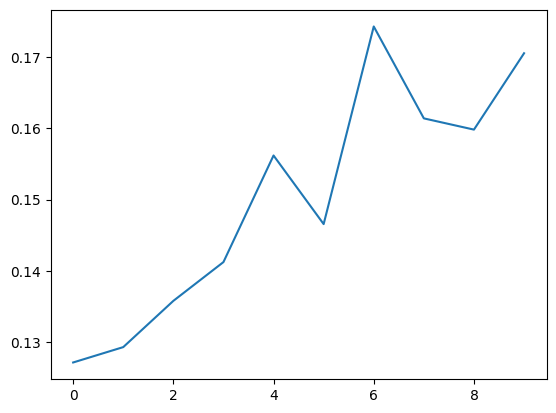

In [ ]:
plt.plot(durations_s)
plt.show()

### Optimizing text generation with KV-caching

KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
- Modify the generate helper function to return the next token and the key/value tensors

In [ ]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [ ]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.6952714920043945 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


- Compare the execution time for the KV-cache function with the original helper function

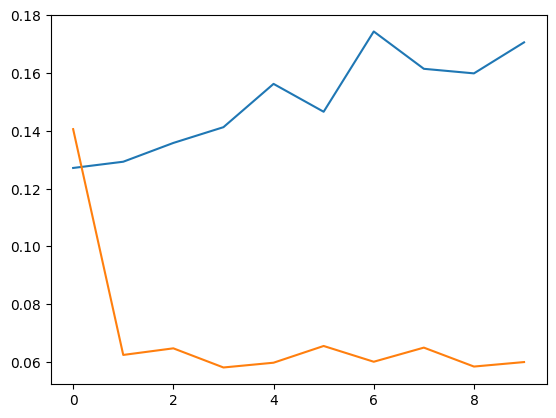

In [ ]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

## Batching

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [ ]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

Reuse KV-cache text generation

In [ ]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


**Add padding tokens to the model to prepare batches of prompts**

In [ ]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

- Tokenize list of prompts
- Add padding so that all prompts have the same number of tokens as the longest prompt

In [ ]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [ ]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [ ]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


- Add position ids to track original order of tokens in each prompt
- Padding tokens are set to `1` and then first real token starts with position `0`

In [ ]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [ ]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [ ]:
last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=1)

print(next_token_ids)

tensor([13990,   319,   307])


In [ ]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

**put it all together**

In [ ]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [ ]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [ ]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [ ]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



### Throughput vs Latency

> **Throughput**: the number of tokens we can generate at the same time

> **Latency**: How long it takes to generate each token

- Explore the effect of batching on latency (how long it takes to generate each token).
- Observe the fundamental tradeoff that exists between throughput and latency.

In [ ]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.7290999889373779
throughput 13.715539914593107
avg latency 0.0729099988937378

bs= 2
duration 1.1314568519592285
throughput 17.676325849605345
avg latency 0.11314568519592286

bs= 4
duration 1.228811264038086
throughput 32.55178494096245
avg latency 0.12288112640380859

bs= 8
duration 1.7085089683532715
throughput 46.82445423573466
avg latency 0.17085089683532714

bs= 16
duration 2.3915843963623047
throughput 66.90125602231156
avg latency 0.23915843963623046

bs= 32
duration 3.4378533363342285
throughput 93.08134137601546
avg latency 0.34378533363342284

bs= 64
duration 4.508948564529419
throughput 141.9399646814987
avg latency 0.4508948564529419

bs= 128
duration 9.249368906021118
throughput 138.38782007783803
avg latency 0.9249368906021118



**Let's plot the throughput and latency observations against the batch size**

In [ ]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

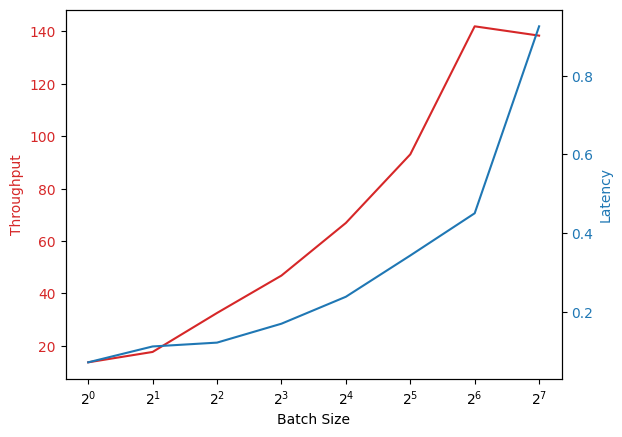

In [ ]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

### Continuous Batching

- The key idea behind continuous batching is constantly swap out requests from the batch that have completed generation for requests in the queue that are waiting to be processed.

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
def get_next_inputs(batch, next_token_ids, past_key_values, next_tokens):
    return {
        # '-1' here means the remaining elements for this dim
        "input_ids": next_token_ids.reshape((-1, 1)),
        # increment last, discard the rest
        "position_ids": batch["position_ids"][:, -1].unsqueeze(-1) + 1,
        # concatenate vector of 1's with shape [batch_size]
        "attention_mask": torch.cat([
            batch["attention_mask"],
            torch.ones((next_token_ids.shape[0], 1)),
        ], dim=1),
        "past_key_values": past_key_values,
        "responses": [
            r1 + r2 for r1, r2
            in zip(batch["responses"], next_tokens)],
        "tokens_remaining": [
            v - 1 for v in batch["tokens_remaining"]],
    }


def init_batch(requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }


def generate_next_token(batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")

    next_token_ids, past_key_values = \
        generate_batch_tokens_with_past(inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(
        batch, next_token_ids, past_key_values, next_tokens)


def merge_batches(batch1, batch2):
    # first find the max sequence length of the two batches
    # this can be obtained from the second dimension
    # of the attention mask
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])

    # pad each mask (on the left) to the max sequence length
    # attention mask uses 0 for padding
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]
    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)

    # because we only append batches post decoding,
    # we don't need to pad input_ids
    # or position_ids. these are always length 1
    # in the sequence dimension
    # however, we do need to pad the
    # past_key_values, which have shape:
    # [batch_size, num_heads, sequence_length, head_dim]
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]

    padded_kv1 = []
    for i in range(len(past_kv1)):
        k, v = past_kv1[i]
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)
        padded_kv1.append((k, v))

    padded_kv2 = []
    for i in range(len(past_kv2)):
        k, v = past_kv2[i]
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)
        padded_kv2.append((k, v))

    # now that everything has been padded to have
    # consistent shapes, let's merge
    input_ids = torch.concat(
        [batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat(
        [batch1["position_ids"], batch2["position_ids"]], dim=0)
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)

    past_kv = []
    for i in range(len(padded_kv1)):
        k1, v1 = padded_kv1[i]
        k2, v2 = padded_kv2[i]
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))

    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }


def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)

    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values

    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting
        # compute cycles on padding tokens,
        # we will left truncate the attention_mask
        # and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by
        # looking for the min first non-zero index
        # of the attention mask
        # cumprod ensures we stop accumulating when we see a 1
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values

    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices

In [ ]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

**Add padding tokens to the model to prepare batches of prompts**

In [ ]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [ ]:
# multiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

**Define needed functions for batching**

In [ ]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }
    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),  # '-1' here means the remaining elements for this dim
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,  # increment last, discard the rest
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  # concatenate vector of 1's with shape [batch_size]
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

**Define the requests to be processed**

In [ ]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

In [ ]:
request_queue[:8]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [ ]:
batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [ ]:
len(batches)

4

In [ ]:
batches[0]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

**Processing batches**

In [ ]:
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})

        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)

        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 4/4 [00:49<00:00, 12.41s/it, max_tokens=100]

duration 49.65493988990784


**Let's try continuous batching**

- This time, rather than processing each batch to completion, you will use continuous batching to dynamically swap in and out inputs from the queue.

In [ ]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]

duration 18.821728467941284


## Quantization

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

In [ ]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
def generate_batch_tokens_with_past(model, inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

def init_batch(tokenizer, requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }

def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)

    completed_responses = [
        r
        for i, r in enumerate(batch["responses"])
        if i in remove_indices
    ]

    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values

    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting compute cycles on padding tokens,
        # we will left truncate the attention_mask and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by looking for the min first non-zero index
        # of the attention mask
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  # cumprod ensures we stop accumulating when we see a 1
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values

    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices, completed_responses

def generate_next_token(model, tokenizer, batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")

    next_token_ids, past_key_values = generate_batch_tokens_with_past(model, inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(batch, next_token_ids, past_key_values, next_tokens)

def generate(model, tokenizer, requests):
    # seed the random number generator so our results are deterministic
    random.seed(42)

    # constants
    batch_size = 8
    request_queue = copy.copy(requests)

    responses = [None] * len(requests)

    # and run the initial prefill step
    batch = init_batch(tokenizer, request_queue[:batch_size])
    cached_batch = generate_next_token(model, tokenizer, batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is fully drained and every input
    # within the cached_batch has completed generation
    while len(request_queue) > 0 or cached_batch["input_ids"].size(0) > 0:
        batch_capacity = batch_size - cached_batch["input_ids"].size(0)
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(tokenizer, request_queue[:batch_capacity])
            new_batch = generate_next_token(model, tokenizer, new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(model, tokenizer, cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices, completed_responses = filter_batch(cached_batch)

        for idx, resp in zip(removed_indices, completed_responses):
            responses[idx] = resp

    return responses

In [ ]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

**Define a Float 32 type**

In [ ]:
# fix dtype post quantization to "pretend" to be fp32
def get_float32_dtype(self):
    return torch.float32
GPT2Model.dtype = property(get_float32_dtype)

In [ ]:
model.get_memory_footprint()

510342192

**Define a quantization function**

In [ ]:
def quantize(t):
    # obtain range of values in the tensor to map between 0 and 255
    min_val, max_val = t.min(), t.max()

    # determine the "zero-point", or value in the tensor to map to 0
    scale = (max_val - min_val) / 255
    zero_point = min_val

    # quantize and clamp to ensure we're in [0, 255]
    t_quant = (t - zero_point) / scale
    t_quant = torch.clamp(t_quant, min=0, max=255)

    # keep track of scale and zero_point for reversing quantization
    state = (scale, zero_point)

    # cast to uint8 and return
    t_quant = t_quant.type(torch.uint8)
    return t_quant, state

In [ ]:
t = model.transformer.h[0].attn.c_attn.weight.data
print(t, t.shape)

tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]]) torch.Size([768, 2304])


In [ ]:
t_q, state = quantize(t)
print(t_q, t_q.min(), t_q.max())

tensor([[107, 116, 124,  ..., 130, 125, 129],
        [132, 135, 139,  ..., 126, 128, 127],
        [128, 131, 145,  ..., 133, 130, 127],
        ...,
        [116, 127, 137,  ..., 129, 126, 130],
        [135, 138, 133,  ..., 129, 126, 126],
        [110, 119, 117,  ..., 128, 128, 129]], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


**Define a dequantization function**

In [ ]:
def dequantize(t, state):
    scale, zero_point = state
    return t.to(torch.float32) * scale + zero_point

In [ ]:
t_rev = dequantize(t_q, state)
print(t_rev)

tensor([[-0.4774, -0.2783, -0.1014,  ...,  0.0313, -0.0793,  0.0092],
        [ 0.0755,  0.1419,  0.2303,  ..., -0.0572, -0.0129, -0.0351],
        [-0.0129,  0.0534,  0.3630,  ...,  0.0976,  0.0313, -0.0351],
        ...,
        [-0.2783, -0.0351,  0.1861,  ...,  0.0092, -0.0572,  0.0313],
        [ 0.1419,  0.2082,  0.0976,  ...,  0.0092, -0.0572, -0.0572],
        [-0.4110, -0.2120, -0.2562,  ..., -0.0129, -0.0129,  0.0092]])


In [ ]:
torch.abs(t - t_rev)

tensor([[0.0035, 0.0170, 0.0036,  ..., 0.0200, 0.0209, 0.0158],
        [0.0119, 0.0055, 0.0084,  ..., 0.0046, 0.0017, 0.0195],
        [0.0168, 0.0161, 0.0038,  ..., 0.0167, 0.0050, 0.0032],
        ...,
        [0.0191, 0.0187, 0.0131,  ..., 0.0004, 0.0056, 0.0006],
        [0.0098, 0.0088, 0.0067,  ..., 0.0202, 0.0143, 0.0097],
        [0.0010, 0.0196, 0.0162,  ..., 0.0084, 0.0199, 0.0107]])

In [ ]:
response_expected = generate(
    model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence and ran to the other side of the fence'

**Let's apply the quantization technique to the entire model**

In [ ]:
def quantize_model(model):
    states = {}
    for name, param in model.named_parameters():
        param.requires_grad = False
        param.data, state = quantize(param.data)
        states[name] = state
    return model, states

In [ ]:
quant_model, states = quantize_model(model)

In [ ]:
quant_model.get_memory_footprint()

137022768

In [ ]:
def size_in_bytes(t):
    return t.numel() * t.element_size()

In [ ]:
sum([
    size_in_bytes(v[0]) + size_in_bytes(v[1])
    for v in states.values()
])

1184

In [ ]:
def dequantize_model(model, states):
    for name, param in model.named_parameters():
        state = states[name]
        param.data = dequantize(param.data, state)
    return model

In [ ]:
dequant_model = dequantize_model(quant_model, states)

In [ ]:
dequant_model.get_memory_footprint()

510342192

In [ ]:
response_expected = generate(
    dequant_model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence.\n\nThe fox jumped over the fence'

# Fine-Tuning

## Parameter-Efficient Fine-Tuning (PEFT)

> **PEFT**: Parameter-Efficient Fine-Tuning of billion-scale models on low-resource hardware. It freezes most parameters of a pre-trained



## Adapter Tuning

Fine-tuning involves copying the weights from a pre-trained network and tuning them on the downstream task (a new set of weights for each task).

Multi-task learning requires simultaneous access to all tasks (memory intense).


**Adapters** yield "**parameter-efficient tuning**" for NLP.
It permits training on tasks **sequentially**!

Tuning with adapter modules involves adding a small number of new parameters to a model, which are trained on the downstream task.

In **adapter-tuning**, the parameters of the original network are **frozen** and therefore may be shared by many tasks.

### AdapterFusion

Sequential fine-tuning and multi-task learning are methods aiming to incorporate knowledge from multiple tasks; however, they suffer from **catastrophic forgetting and difficulties in dataset balancing**. To address these shortcomings, AdapterFusion, a new two stage learning algorithm that leverages knowledge from multiple tasks was proposed.

Example, if you have 100 dataset, and 100 tasks, after lots of sequential fine-tuning the model might overwrite what it has learned.

In this appraoch, each dataset has its own adapters. And there's one AdapterFusion layer for all.

![adapterfusion architecture#](https://voicelab.ai/wp-content/uploads/obraz9.png)

## Low-Rank Adaptation (LoRA)

Goal: Loading a large model into a GPU with lower VRAM and being able to do calculations.



> **LoRA**: Low-Rank Adaptation, a random projection to a smaller subspace. Freezes pre-trained model weights and injects trainable rank decomposition matrices inot each layer of Transformer


**LoRA**

$$
W_0 + \Delta W = W_o + BA
$$

Where:
- $W_0$ Original untouch model weights
- $B$ Low rank matrix, $B \in R^{dxr}$, $B$ is set to zero
- $A$ Low rank matrix, $A \in R^{rxk}$, $A$ is sampled from Normal Distribution
  - rank r << min(d,k)

In the Forward Pass:

$$
h = W_0x+\Delta Wx = W_0x+ BAx \\
$$

BA is acheived through SVD compression

$$
\begin{align*}
M &= USV^T \\
&= (US)V^T \\
&= LR^T, \text{ where} \\
L &= (US), \text{ and} \\
R &= V
\end{align*}
$$

```python
def regular_forward_matmul(x, W):
  h = x @ W
  return h

def lora_forward_matmul(x, W, W_A, W_B):
  h = x @ W # regular matrix multiplication
  h += x @ (W_A @ W_B)*alpha # use scaled LoRA weights
  return h

```

$BA$ is scaled by $\frac{\alpha}{r}$

- $r$: The intrinsic dimension, which means to what extent we want to decompose the matrices. Typical numbers range from 1 to 64, and express the amount of compression on the weights.

- $\alpha$: Scaling factor. It controls the amount of change that is added to the original model weights. Using zero will output the original model, and using 1 will output the fully fine-tuned model, and anything larger will be amplifying it's effect.

### Implementing LoRA

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# set the seed so we get the same results from here on for each run
torch.manual_seed(42)

**Create a test Model**

In [ ]:
class TestModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(10, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, hidden_size)
        self.lm_head = torch.nn.Linear(hidden_size, 10)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.linear(x)
        x = self.lm_head(x)
        return x

In [ ]:
# set a reasonably large hidden size to illustrate the small fraction of
# params needed to be added for LoRA
hidden_size = 1024
model = TestModel(hidden_size)

In [ ]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
# toy example of a detokenizer.
# The vocabulary only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [ ]:
# this is the same generation step as we saw in lesson 2 (batching)
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [ ]:
# generate one token
next_token = generate_token(model, input_ids=input_ids)[0]
next_token

'magenta'

In [ ]:
# dummy input tensor
# shape: (batch_size, sequence_length, hidden_size)
X = torch.randn(1, 8, 1024)

**Let's set up the LoRA computation¶**

In [ ]:
# LoRA A and B tensors
# A has shape (hidden_size, rank)
# B has shape (rank, hidden_size)
R=2 # hyperparameter rank
lora_a = torch.randn(1024, R)
lora_b = torch.randn(R, 1024)

In [ ]:
W = model.linear.weight

In [ ]:
W.shape

torch.Size([1024, 1024])

In [ ]:
W2 = lora_a @ lora_b

In [ ]:
W2.shape

torch.Size([1024, 1024])

In [ ]:
# Compare number of elements of A and B with number of elements of W
# W here has shape (hidden_size, hidden_size)
lora_numel = lora_a.numel() + lora_b.numel()
base_numel = W.numel()
print("|A+B| / |W|:", lora_numel / base_numel)

|A+B| / |W|: 0.00390625


Let's run the LoRA computation

In [ ]:
# compute the output of X @ W (the original linear layer)
base_output = model.linear(X)

# compute the output of X @ A @ B (the added lora adapter)
lora_output = X @ lora_a @ lora_b

# sum them together
total_output = base_output + lora_output

# output should have the same shape as the original output:
# (batch_size, sequence_length, hidden_size)
total_output.shape

torch.Size([1, 8, 1024])

In [ ]:
class LoraLayer(torch.nn.Module):
    def __init__(self, base_layer, r):
        super().__init__()
        self.base_layer = base_layer

        d_in, d_out = self.base_layer.weight.shape
        self.lora_a = torch.randn(d_in, r)
        self.lora_b = torch.randn(r, d_out)

    def forward(self, x):
        y1 = self.base_layer(x)
        y2 = x @ self.lora_a @ self.lora_b
        return y1 + y2

In [ ]:
# wrap the linear layer of our toy model, use rank 2
lora_layer = LoraLayer(model.linear, 2)
lora_layer(X).shape

torch.Size([1, 8, 1024])

In [ ]:
model.linear = lora_layer

In [ ]:
model

TestModel(
  (embedding): Embedding(10, 1024)
  (linear): LoraLayer(
    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)

**Let's try the generate token after adding the LoRA layer**

In [ ]:
next_token = generate_token(model, input_ids=input_ids)
next_token[0]

'chartreuse'

### Implementing Multi-LoRA

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

**Let's create a new model**

It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [ ]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # hidden_size = 10
        # set this so low to ensure we are not
        # compute-bound by the linear layer
        # this is only an issue when running on CPU,
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

**Using a loop**

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [ ]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [ ]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [ ]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
torch.manual_seed(42)

In [ ]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [ ]:
model = LoopMultiLoraModel()

**Let's try it!**

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [ ]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


**Let's benchmark our multi-LoRA system!**

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [ ]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [ ]:
avg_latencies_loop = benchmark(model)

**Let's visualize it!**

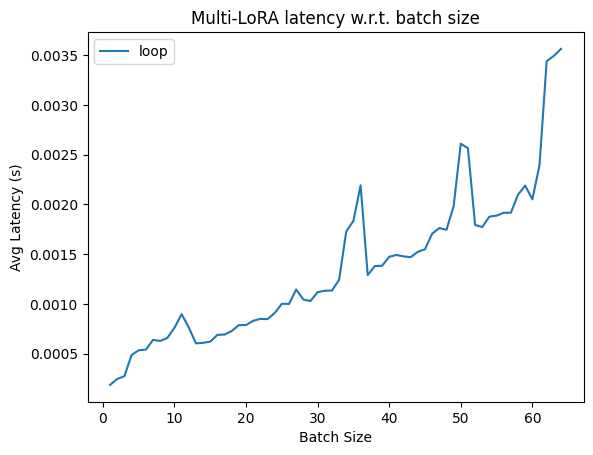

In [ ]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

**Let's vectorize the LoRA computation**

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [ ]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)

        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [ ]:
model = GatheredMultiLoraModel()

In [ ]:
avg_latencies_gathered = benchmark(model)

**Let's visualize it!**

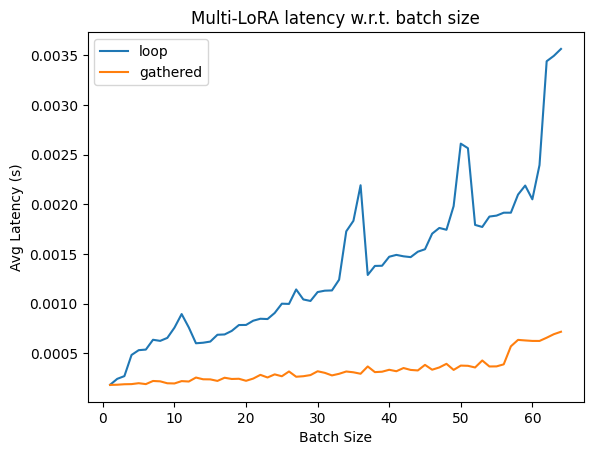

In [ ]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

## Quantization

The weights stored in model use 32-bit floating-point numbers.

**Quantization** is a technique to reduce the precision of the numbers used in the model. For example, in 4-bit quantization, the weights and activations of the network are compressed from 32-bit floating-point numbers to 4-bit integers.

### 4-Bit NormalFloat Quantization

A 4-bit integer can range from -8 to 7! How!?

1. **Normalization:** The weights of the model are first normalized to have **zero mean** and **unit variance**. This ensures that the weights are **distributed around zero** and fall within a certain range.

2. **Quantization:** The normalized weights are then **quantized to 4 bits**. This involves mapping the original high-precision weights to a smaller set of low-precision values. In the case of NF4, the **quantization levels are chosen to be evenly spaced** in the range of the normalized weights.

3. **Dequantization:** During the forward pass and backpropagation, the quantized weights are **dequantized back to full precision**. This is done by mapping the 4-bit quantized values back to their original range. The dequantized weights are used in the computations, but they are stored in memory in their 4-bit quantized form.



Note that while the weights are stored as 4-bit integers, they are typically converted back to 32- bit floating-point numbers for the actual computations.

**Example**

A weight in our NN that is a 32-bit floating-point number, and its value is 0.5678.

Let's say our 4-bit integers represent 16 levels evenly spaced between -1 and 1. These levels would be: -1.0, -0.8667, -0.7333, -0.6, -0.4667, -0.3333, -0.2, -0.0667, 0.0667, 0.2, 0.3333, 0.4667, 0.6, 0.7333, 0.8667, 1.0

Our original weight value of 0.5678 is closest to 0.6, so we would quantize this weight to 0.6.

In our 4-bit representation, let's say 0.6 corresponds to the integer 13. We store the 4-bit integer 13 instead of the 32-bit floating-point number 0.5678.

If we use this weight in a computation, we first dequantize it back (0.6) to the floating-point number. The dequantization error is 0.6 -0.5678 = 0.0322 (rem: 1 level spaced out is 0.1333-> 1/4 of a space)

### Quantization and Low Rank Adaptors (QLoRA)

4-bit Integer Quantization of original 32-bit weights and apply **Parameter Efficient Fine Tuning (PEFT)**, inject LoRA adapters into each layer, in 32-bit precision, and start to **fine-tune the complete Language model** on a specific task, for the quantized configuration to reduce quantization error of the system.

Around 1% of all tensor weights are injected LoRa adapter weight tensors, in 32-bit precision

If we have a 175B model, we have more than 1 billion injected adapter weights in 32-bit precision.

The injected LoRA weight tensors are the only trainable parameters. The rest of the params (the other 99%) are frozen.


$$
\begin{matrix}
\ddots & \vdots & \vdots & \vdots & ⋰\\
\cdots & 4bit & 4bit & 4bit & \cdots \\
\cdots & 4bit & 32bit & 4bit & \cdots \\
\cdots & 4bit & 4bit & 4bit & \cdots \\
⋰ & \vdots & \vdots & \vdots & \ddots \\
\end{matrix} \\
$$

The $32bit$ weight is the LoRA adapter.

During computation (forward pass or backward propogation), **dequantization** happens:

$$
\begin{matrix}
\ddots & \vdots & \vdots & \vdots & ⋰\\
\cdots & 32bit & 32bit & 32bit & \cdots \\
\cdots & 32bit & 32bit & 32bit & \cdots \\
\cdots & 32bit & 32bit & 32bit & \cdots \\
⋰ & \vdots & \vdots & \vdots & \ddots \\
\end{matrix} \\
$$

This process is not save in memory, dequantization only happens during computation.

After backpropogation, only the LoRA weight is updated ($32bit \rightarrow {32bit}^*$), and the rest of the weights are restored to the $4bit$ version.

$$
\begin{matrix}
\ddots & \vdots & \vdots & \vdots & ⋰\\
\cdots & 4bit & 4bit & 4bit & \cdots \\
\cdots & 4bit & {32bit}^* & 4bit & \cdots \\
\cdots & 4bit & 4bit & 4bit & \cdots \\
⋰ & \vdots & \vdots & \vdots & \ddots \\
\end{matrix} \\
$$


Each dequantized weight, would have a precision error when converted to full-bit size due to the rounding happening at the quantization time.

The LoRA weight tensor is not affect by dequantization-error as it never gets quantized.


With the QLORA fine-tuning the system (NN) learns the new specific task it is fine-tuned on, given its actual **dequantization error** of every single weight tensor (kept frozen, not updated) of **4-bit precision**.

The additional low-rank adapters in the QLORA method are in a higher precision format, typically 32-bit floating-point (bflaot16), for a few reasons:

- Higher precision allows the model to capture more subtle patterns in the data. This is particularly important for the low-rank adapters, as they are responsible for adapting the pre-trained model to the specific task it is being fine-tuned for.

- Training neural networks involves a lot of incremental updates to the weights. Weights in a higher precision format ensures that updates are accurately captured.

- While quantizing all weights can save memory, the computational efficiency might not always improve. GPUs are optimized for 32-bit (bfloat16) operations. Computations w/ 32-bit floating-point can be faster than with lower precision.

#### Implementation

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install `einops` as it is a requirement to load Falcon models.

In [ ]:
# From Artidoro Pagnoni @ https://colab.research.google.com/drive/1BiQiw31DT7-cDp1-0ySXvvhzqomTdI-o?usp=sharing
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

**Dataset**

For our experiment, we will use the Guanaco dataset, which is a clean subset of the OpenAssistant dataset adapted to train general purpose chatbots.

The dataset can be found [here](https://huggingface.co/datasets/timdettmers/openassistant-guanaco)

In [ ]:
from datasets import load_dataset

dataset_name = "timdettmers/openassistant-guanaco"
dataset = load_dataset(dataset_name, split="train")

**Loading the model**

In this section we will load the [Falcon 7B model](https://huggingface.co/tiiuae/falcon-7b), quantize it in 4bit and attach LoRA adapters on it. Let's get started!

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "ybelkada/falcon-7b-sharded-bf16"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

In [ ]:
# load the tokenizer below
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Below we will load the configuration file in order to create the LoRA model. According to QLoRA paper, it is important to consider all linear layers in the transformer block for maximum performance. Therefore we will add `dense`, `dense_h_to_4_h` and `dense_4h_to_h` layers in the target modules in addition to the mixed query key value layer.

In [ ]:
from peft import LoraConfig

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

**Loading the trainer**

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 10
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 500
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=True,
)

Then finally pass everthing to the trainer

In [ ]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

**Train the model**

Now let's train the model! Simply call `trainer.train()`

In [ ]:
trainer.train()

During training, the model should converge nicely as follows:

![image](https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/loss-falcon-7b.png)

The `SFTTrainer` also takes care of properly saving only the adapters during training instead of saving the entire model.

**Save and Loading fine-tuned model**

In [ ]:
output_dir="fine-tuned-model"

model.save_pretrained(output_dir)

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

config = PeftConfig.from_pretrained(output_dir)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

### Mixed Precision Training

Perform additionally a **mixed precision training** to balance the trade-off between accuracy and speed/memory usage.

With all optimization steps and additional training of the model, 4-bit QLoRA performs equivalent to a bfloat16 model.

**8-bit** binary number `11010110` represents the decimal number 214 (max 255)

**16-bit integers** can represent values between 0 and 65,535 for unsign int.

**float16**: 0 11101 1010000000 is the number 52736 (16-bit binary format, first digit is the sign, the next 5 are the exponents, and the rest are the mantissa bits.).

**bfloat16**: one sign bit, eight exponent bits, and seven mantissa bits.

> Hardware multiplier scales with the square of the mantissa width


The *physical size* of **bfloat16 multiplier**s are **half the size in silicon of a FP16** multiplier, and are **eight times smaller than an float32** multiplier.

> Neural networks are more sensitive to the size of the Exponent than the size of the mantissa.

To ensure identical behavior **bfloat16** has **the same Exponent size as float32** (both have 8bit exponent size). Google optimized TPUs (also) for bfloat16.

Mixed-precision training: **XLA compiler** automatically converts values between float32 and bfloat16. -> PyTorch 2.0, pure in JAX and in TensorFlow2